# Numba and GPUs

Numba supports Nvidia and AMD GPUs. In this course, however, we are going to focus on CUDA capable GPUs from Nvidia. There are two reasons for that: CUDA is better supported and we don't have any AMD system that can run Numba on the GPU right now.

If you want to use an already installed CUDA SDK, there are two environment variables that need to be set to let numba know where it can find the libraries it needs. On JURECA this can be done like this:

```bash
export NUMBAPRO_NVVM=$CUDA_HOME/nvvm/lib64/libnvvm.so
export NUMBAPRO_LIBDEVICE=$CUDA_HOME/nvvm/libdevice/
```

For other systems you will have to adjust the paths.

## Ufunc

We already learned how to vectorize a function. Remember the Mandelbrot set. We defined a function that returns the number of iterations needed to decide if the algorithm diverges.

In [1]:
from numba import vectorize

def escape_time(p, maxtime):
    """Perform the Mandelbrot iteration until it's clear that p diverges
    or the maximum number of iterations has been reached.
    """
    z = 0j
    for i in range(maxtime):
        z = z ** 2 + p
        if abs(z) > 2:
            return i
    return maxtime

In [2]:
import numpy
x = numpy.linspace(-2, 2, 100)
y = numpy.linspace(-1.5, 1.5, 75)
zr, zc = numpy.meshgrid(x, 1j * y)

In [3]:
escape_time_v = vectorize("int64(complex128, int64)", 
                          target="parallel")(escape_time)

In [4]:
t_cpu = %timeit -o escape_time_v(zr + zc, 10)

The slowest run took 150.33 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 88.9 µs per loop


If you replace `target="parallel"` with `target="cuda"` the function runs on the GPU instead. Give it a try and compare the performance for different sizes:

In [6]:
escape_time_v = vectorize("int64(complex128, int64)", 
                          target="cuda")(escape_time)
t_cpu = %timeit -o escape_time_v(zr + zc, 10)

The slowest run took 106.93 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 1.11 ms per loop


## CUDA for Python

Numba allows you to write CUDA programs in Python. 

While a complete introduction to CUDA is beyond the scope of this course---there are other courses for this, for example, GPU Programming with CUDA @ JSC and also many online resources available---here you'll get the nutshell version and some of the differences between CUDA C++ and CUDA Python.

## CPU vs. GPU

CPUs are optimized for latency.

A CPU tries to execute a given instruction as quickly as possible, i.e., it tries to keep the latency (the time between issuing and executing an instruction) as short as possible. CPUs use caches and a lot of control logic to achieve this goal.

GPUs are optimized for throughput.

GPUs were (and are) made to display graphics on your screen. It doesn't matter how quickly a GPU can update a single pixel. It's important how quickly it can update all of the pixels on the screen (more than 2 million on an HD display). In addition it often must perform the same operation on a lot of vertices or pixels. 

These two conditions let to a different execution model.


## GPU execution model

GPUs use *many* lightweight threads.

GPUs hide latency instead of avoiding it

GPUs work best if the problem can me mapped on a grid.

# Kernels

We can calculate the Mandelbrot set using `escape_time` like this:

In [7]:
maxiter = 20
rlim = (-2.2, 1.5)
ilim = (-1.5, 1.5)
nx = 100
ny = 75

dx = (rlim[1] - rlim[0]) / nx
dy = (ilim[1] - ilim[0]) / ny

M = numpy.zeros((ny, nx), dtype=int)

for i in range(ny):
    for j in range(nx):
        p = rlim[0] + j * dx + (ilim[0] + i * dy) * 1j
        M[i, j] = escape_time(p, maxiter)

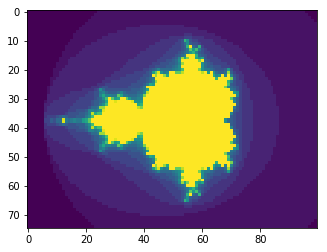

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(M, interpolation="nearest")

Notice that for every pair (i, j), we calculate the escape time. This makes

```python
        p = rlim[0] + j * dx + (ilim[0] + i * dy) * 1j
        M[i, j] = escape_time(p, maxiter)
```

our kernel that we execute on the grid spanned by the two for loops. It's quite apparent on the image above, where the coordinates for each value are shown in index space.

## Threads and blocks and grids, oh my!

The basic unit of execution is a thread. Each thread has an x, y, and z index that can be queried in a kernel.

``` python
from numba import cuda

@cuda.jit
def my_kernel:
    x,y,z = cuda.grid(3) # use 2 if you only need x, y and 1 for x
```



Threads are organized in blocks. The maximum dimension of a thread block is 1024x1024x64, where the volume of the thread block (the number of threads in the block) must be 1024 or less.

Blocks are organized in a grid to cover all the threads needed to solve you problem. The maximum grid dimensions are 2147483647x65535x65535 blocks!

## Writing a kernel

For writing a CUDA kernel, we use `cuda.jit` instead of `jit` as decorator (see above). The kernel can also call other functions that have been decorated with `cuda.jit(device=True)`. A Mandelbrot kernel could look like this:

In [9]:
import numpy
from numba import cuda

escape_time_gpu = cuda.jit(device=True)(escape_time)

@cuda.jit
def mandelbrot_gpu(M, real_min, real_max, imag_min, imag_max):
    """Calculate the Mandelbrot set on the GPU.
    
    Parameters
    ----------
    M : numpy.ndarray
        a two-dimensional integer array that will contain the 
        escape times for each point.
    real_min: float
        minimum value on the real axis
    real_max: float
        maximum value on the real axis
    imag_min: float
        minimum value on the imaginary axis
    imag_max: float
        maximum value on the imaginary axis
    """
    ny, nx = M.shape
    i, j = cuda.grid(2)
    
    if i < ny and j < nx:
        dx = (real_max - real_min) / nx
        dy = (imag_max - imag_min) / ny
        p = real_min + dx * i + (imag_min + dy * j) * 1j
        M[i, j] = escape_time_gpu(p, 20)

## Calling a kernel

CUDA needs to know how many blocks and how many threads per block you want to launch. This is called the launch configuration. To calculate the Mandelbrot set with of two 1024 by 1024 points with a block size of 32 by 32, we need 1024/32=32 by 1024/32=32 blocks.

If we want to calculate the set for 1032 by 1032 points, we have to add an extra block. The following lines take care of that:

In [10]:
M = numpy.zeros((1024, 1024), dtype=numpy.int32)
block = (32, 32)
grid = (M.shape[0] // block[0] if M.shape[0] % block[0] == 0 
            else M.shape[0] // block[0] + 1,
        int(M.shape[0] // block[1] if M.shape[1] % block[1] == 0 
            else M.shape[1] // block[1] + 1))

The launch configuration is passed in square brackets before the function arguments.

In [11]:
mandelbrot_gpu[grid, block](M, -2.0, 2.0, -1.6, 1.6)

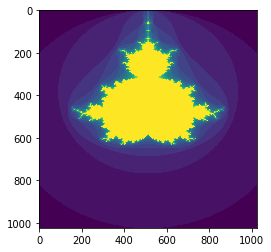

In [12]:
plt.imshow(M, interpolation="nearest")

## Exercise: Profile the Mandelbrot calculation on the GPU

a) Use %timeit to measure the speed of the GPU implementation compared to the vectorized version.

The kernel calculates dx and dy for every pixel although it is the same for all of them. Change the kernel so that it takes dx and dy as arguments and calculate dx and dy before you call the kernel. Does this improve the performance?

## Exercise: Matrix multiplication

Write a kernel, where each thread calculates one element of the result matrix $C=AB$, where A and B are matrices.

For the algorithm, you can take a look at Bottlenecks.

## Using shared memory

As you learned in Bottlenecks, the matrix matrix multiplication tends to be memory bandwidth bound. This is true on the GPU, too.

The way to make it faster is to use faster memory. On a CPU this usually means, dividing the matrix into blocks that fit in cache and hope for the best. On a GPU at lease part of the fast memory is usually programmable. In CUDA this memory is called *shared memory*.

Shared memory is available to all *threads in a thread block*. Usually, each thread loads data from device memory into shared memory. This is followed by barrier, so that all threads are finished reading. Then the shared memory is reused as often as possible. Another barrier makes sure that all threads are done.

Let's look at an example:

## Matrix multiplication with shared memory

The following function performs a matrix multiplication on the GPU using shared memory.

In [ ]:
from numba import cuda, float32

# Controls threads per block and shared memory usage.
# The computation will be done on blocks of TPBxTPB elements.
TPB = 16

@cuda.jit
def fast_matmul(A, B, C):
    # Define an array in the shared memory
    # The size and type of the arrays must be known at compile time
    sA = cuda.shared.array(shape=(TPB, TPB), dtype=float32)
    sB = cuda.shared.array(shape=(TPB, TPB), dtype=float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    if x >= C.shape[0] and y >= C.shape[1]:
        # Quit if (x, y) is outside of valid C boundary
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of TPB-long vectors.
    tmp = 0.
    for i in range(bpg):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * TPB]
        sB[tx, ty] = B[tx + i * TPB, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(TPB):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

The above example shows most special functions used in CUDA kernels:

All the cuda specific API is found in numbas cuda module (line 1) 

CUDA kernels are defined like regular Python functions with the added decorator `@cuda.jit` (line 7). The decorator makes sure that the function is compiled for the GPU.

As mentioned above, CUDA kernels are executed as a grid of blocks of threads. cuda.grid (line 14) returns the global indices of the current thread, e.g., `x, y = cuda.grid(2)` for a two dimensional grid. The argument gives the number of dimensions (1, 2, 3). This function does not exist in CUDA C++.

In CUDA C++, the programmer usually calculates the global index from the thread index `threadIdx`, the block index `blockIdx`, and the size (dimension) of the block stored in `blockDim`

```C++
int x = blockIdx.x * blockDim.x + threadIdx.x;
```

In numba these are available through the cuda module, so that you can rewrite the C++ code above as 

```Python
x = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
```

In `fast_matmul` these functions are used to get the local index of the thread, which is important to use the shared memory (lines 16--18).

Shared memory is a programmable cache accessible to all threads within a block. In C++ it is allocated within a kernel as

```C++
__shared__ float sA[TPB, TPB]; // Allocate a 2D array of floats of size TPB
```

The cuda module provides shared.array (line 11 & 12) to do the same thing.

The last function from the cuda module used in `fast_matmul` is cuda.syncthreads(), which implements a barrier for the threads within a block. It corresponds to `__syncthreads()` in CUDA C++.

These functions cover most kernels.

Not all CUDA features are implemented in Numba. Some missing features are listed at http://numba.pydata.org/numba-doc/dev/cuda/overview.html#missing-cuda-features. Currently they include dynamic parallelism and texture memory.